In [15]:
!pip install --upgrade pip
!pip3 install numpy pandas matplotlib scikit-learn tensorflow transformers torch Pillow requests pyngrok streamlit deep_translator googletrans==4.0.0-rc1

In [16]:
import numpy as np
import pandas as pd
import os
import re
import pickle
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, concatenate, Layer, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications import VGG16, DenseNet201
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import random
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import os


In [17]:
data_path = "C:\\Users\\nour sharawy\\Downloads\\captions.txt"
image_dir =  "C:\\Users\\nour sharawy\\Downloads\\Flicker8k_Dataset"
features_path =  "C:\\Users\\nour sharawy\\Downloads\\features.pkl"
tokenizer_path =  "C:\\Users\\nour sharawy\\Downloads\\tokenizer.pkl"
model_weights_dir =  "C:\\Users\\nour sharawy\\Downloads\\ImageCaptioningModels_Org"
os.makedirs(model_weights_dir, exist_ok=True)
print(f" Paths: \n{data_path}\n{image_dir}\n{features_path}\n{tokenizer_path}\n{model_weights_dir}")

 Paths: 
C:\Users\nour sharawy\Downloads\captions.txt
C:\Users\nour sharawy\Downloads\Flicker8k_Dataset
C:\Users\nour sharawy\Downloads\features.pkl
C:\Users\nour sharawy\Downloads\tokenizer.pkl
C:\Users\nour sharawy\Downloads\ImageCaptioningModels_Org


C:\Users\nour sharawy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


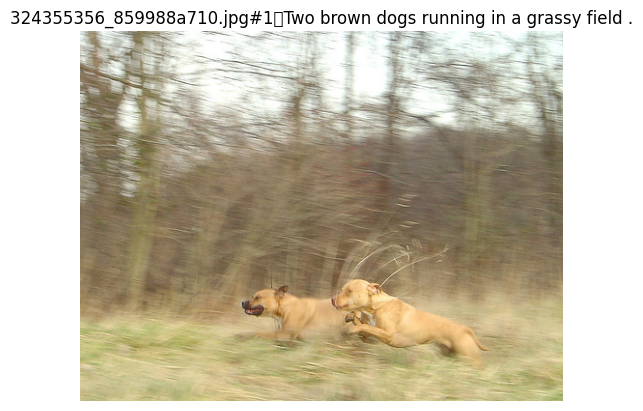

In [18]:
def display_random_image_with_caption(data_path, image_dir):
    with open(data_path, 'r') as file:
        captions = file.readlines()
    
    caption = random.choice(captions).strip()
    image_id = caption.split('#')[0] 
    image_path = os.path.join(image_dir, image_id)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Usage
display_random_image_with_caption(data_path, image_dir)

In [19]:
# 3. Text Cleaning and Tokenizer Preparation
data = pd.read_csv(data_path,  
                 delimiter='\t',
                 header=None,
                 names=['img_files', 'descriptions'])
print(f"Successfully retrieved {len(data)} records")
if 'img_files' not in data.columns or 'descriptions' not in data.columns:
    raise ValueError("Required fields 'img_files' or 'descriptions' not found")
data['image'] = data['img_files'].astype(str).apply(lambda x: x.split('#')[0])  # Clean image name
data['caption'] = data['descriptions'].astype(str)  # Fixed from 'captions' to 'descriptions'
print(f"Sample processed image: {data['image'].iloc[0]}")
print(f"Unique images count: {data['image'].nunique()}")

Successfully retrieved 40455 records
Sample processed image: 1000268201_693b08cb0e.jpg
Unique images count: 8091


In [ ]:
def cleandescriptions(text ,add_special_tokens=True, keep_numbers=False):
    text = text.lower()  
    if keep_numbers:
        pattern = r'[^a-z0-9 ]' # Keep lowercase letters, numbers, and spaces
    else:
        pattern = r'[^a-z ]'  # Keep only lowercase letters and spaces
    text = re.sub(pattern, '', text)      # Remove characters that match the defined pattern
    
    # White space normalization
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Optional sequence tokens
    if add_special_tokens:
        text = 'startseq ' + text + ' endseq'
    
    return text
data['caption_cleaned'] = data['caption'].apply(cleandescriptions)
print("\nText cleaning examples:")
print("Original:", data['caption'].iloc[0])
print("Processed:", data['caption_cleaned'].iloc[0])
# Check if a tokenizer file already exists at the specified path
if os.path.exists(tokenizer_path):
    print("\nLoading existing tokenizer...")   # If it exists, load it from the file using pickle
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f) 
    print(f"Tokenizer loaded with {len(tokenizer.word_index)} vocabulary items") 
else:
    print("\nCreating new tokenizer...")   # If it doesn't exist, create a new tokenizer
    tokenizer = Tokenizer(
        num_words=None,  # You can set a limit here (e.g., 5000)
        filters='',  # We already did our own filtering
        oov_token='<unk>'  # Add out-of-vocabulary token
    )
    tokenizer.fit_on_texts(data['caption_cleaned'])
    
    # Save tokenizer
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    
    print(f"New tokenizer created with {len(tokenizer.word_index)} vocabulary items")
    print("Sample word index:", list(tokenizer.word_index.items())[:5])
vocab_size  = len(tokenizer.word_index) + 1  
lengths = [len(txt.split()) for txt in data['caption_cleaned']]
max_length = max(lengths)
avg_length = sum(lengths)/len(lengths)

print("\nVocabulary statistics:")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Max sequence length: {max_length}")
print(f"- Average sequence length: {avg_length:.1f}")
print(f"- 95th percentile length: {sorted(lengths)[int(len(lengths)*0.95)]}")


Text cleaning examples:
Original: A child in a pink dress is climbing up a set of stairs in an entry way .
Processed: startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq

Loading existing tokenizer...
Tokenizer loaded with 8767 vocabulary items

Vocabulary statistics:
- Vocabulary size: 8768
- Max sequence length: 37
- Average sequence length: 12.8
- 95th percentile length: 20


In [21]:
def extract_features():
   
    print(f"Extracting features using {model_type.upper()}...")
    if model_type == 'densenet':
        model = DenseNet201(include_top=False, weights='imagenet', pooling='avg')
        preprocess = tf.keras.applications.densenet.preprocess_input
    else:
        model = VGG16(include_top=False, weights='imagenet', pooling='avg')
        preprocess = tf.keras.applications.vgg16.preprocess_input
    
    features = {}
    missing_images = []
    
    
    for img_name in tqdm(data['image'].unique(), desc="Processing Images"):
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            missing_images.append(img_name)
            continue
            
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess(np.expand_dims(img_array, axis=0))
            feature = model.predict(img_array, verbose=0).squeeze()
            features[img_name] = feature
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")
    
    return features, missing_images


if os.path.exists(features_path):
    print(" Loading pre-existing features...")
    with open(features_path, 'rb') as f:
        features = pickle.load(f)
    print(f" Loaded {len(features)} features from {features_path}")
else:
    features, missing_images = extract_features()
    print(f"Saving {len(features)} features to {features_path}...")
    with open(features_path, 'wb') as f:
        pickle.dump(features, f)
    
    if missing_images:
        print(f" Could not process {len(missing_images)} images")
example_feature = next(iter(features.values()))
feature_size = example_feature.shape[-1]
if features:
    sample_feature = next(iter(features.values()))
    print("\nFeature Analysis:")
    print(f"Shape: {sample_feature.shape}")
    print(f"Size: {sample_feature.shape[-1]} dimensions")
    print(f"Sample values: {sample_feature[:5]}")
    
    # Statistics
    all_features = np.array(list(features.values()))
    print("\n Statistics:")
    print(f"Min: {np.min(all_features):.4f}")
    print(f"Max: {np.max(all_features):.4f}")
    print(f"Mean: {np.mean(all_features):.4f}")
    print(f"Std Dev: {np.std(all_features):.4f}")
else:
    print("No features were loaded or extracted")


 Loading pre-existing features...
 Loaded 8091 features from C:\Users\nour sharawy\Downloads\features.pkl

Feature Analysis:
Shape: (1, 1920)
Size: 1920 dimensions
Sample values: [[7.8687917e-05 7.3524064e-04 1.1395990e-03 ... 5.6523514e-01
  2.2903775e-01 6.9639796e-01]]

 Statistics:
Min: 0.0000
Max: 19.6174
Mean: 0.3019
Std Dev: 0.6359


In [22]:
sequences = tokenizer.texts_to_sequences(data['caption_cleaned'])  
X_seq = pad_sequences(sequences, maxlen=max_length, padding='post')  #  same length 0000


image_to_seq_map = {}
for img_name, seq in zip(data['image'], X_seq):
    if img_name not in image_to_seq_map:
        image_to_seq_map[img_name] = []
    image_to_seq_map[img_name].append(seq)

In [23]:
tf.random.set_seed(42)
np.random.seed(42)
unique_images = data['image'].unique()
img_train_names, img_val_names = train_test_split(unique_images, test_size=0.2) 
print("train images:", len(img_train_names), ", Value images:", len(img_val_names))

train images: 6472 , Value images: 1619


In [24]:
class DataGenerator(Sequence):
    def __init__(self, img_names, image_to_seq_map, features, batch_size, max_length, vocab_size, shuffle=True):
        self.img_names = img_names
        self.image_to_seq_map = image_to_seq_map
        self.features = features
        self.batch_size = batch_size
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle

        # Validate and prepare data pairs
        self.pairs = self._validate_and_prepare_pairs()
        self.indices = np.arange(len(self.pairs))
        self.on_epoch_end()
        
        # Pre-allocate memory for batch storage
        feature_dim = next(iter(features.values())).shape[-1]
        self.X_img_batch = np.zeros((batch_size, feature_dim))
        self.X_seq_batch = np.zeros((batch_size, max_length))
        self.y_batch = np.zeros((batch_size, vocab_size))

    def _validate_and_prepare_pairs(self):
        pairs = []
        missing_images = 0
        missing_sequences = 0
        
        for img_name in self.img_names:
            if img_name not in self.features:
                missing_images += 1
                continue
                
            if img_name not in self.image_to_seq_map:
                missing_sequences += 1
                continue
                
            sequences = self.image_to_seq_map[img_name]
            for seq in sequences:
                if len(seq) > 1:  # Only include sequences with at least 2 tokens
                    pairs.append((img_name, seq))
        
        if missing_images > 0:
            print(f"Warning: {missing_images} images missing from features")
        if missing_sequences > 0:
            print(f"Warning: {missing_sequences} images missing sequences")
            
        print(f"Created {len(pairs)} valid (image, sequence) pairs")
        return pairs

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_pairs = [self.pairs[i] for i in batch_indices]
        
        batch_size = len(batch_pairs)
        X_img = np.zeros((batch_size, self.X_img_batch.shape[1]))
        X_seq = np.zeros((batch_size, self.max_length))
        y = np.zeros((batch_size, self.vocab_size))
        
        for i, (img_name, seq) in enumerate(batch_pairs):
            img_feature = self.features[img_name].squeeze()
            
            seq_len = min(len(seq), self.max_length + 1)
            if seq_len > 1:
                pos = np.random.randint(1, seq_len) if self.shuffle else 1
                input_seq = pad_sequences([seq[:pos]], maxlen=self.max_length, padding='post')[0]
                output_word = to_categorical([seq[pos]], num_classes=self.vocab_size)[0]
                
                X_img[i] = img_feature
                X_seq[i] = input_seq
                y[i] = output_word
        
        return [X_img, X_seq], y

batch_size = 32
train_gen = DataGenerator(
    img_names=img_train_names,
    image_to_seq_map=image_to_seq_map,
    features=features,
    batch_size=batch_size,
    max_length=max_length,
    vocab_size=vocab_size,
    shuffle=True
)

val_gen = DataGenerator(
    img_names=img_val_names,
    image_to_seq_map=image_to_seq_map,
    features=features,
    batch_size=batch_size,
    max_length=max_length,
    vocab_size=vocab_size,
    shuffle=False
)

# Verify the generator
sample_X, sample_y = train_gen[0]
print("\nBatch shape verification:")
print(f"Image features: {sample_X[0].shape}")
print(f"Input sequences: {sample_X[1].shape}")
print(f"Target words: {sample_y.shape}")

Created 32360 valid (image, sequence) pairs
Created 8095 valid (image, sequence) pairs

Batch shape verification:
Image features: (32, 1920)
Input sequences: (32, 37)
Target words: (32, 8768)


In [25]:
def train_model(model, model_name, train_gen, val_gen, model_weights_dir, epochs=15):
    model_weights_path = os.path.join(model_weights_dir, f"{model_name}_full_model.keras")
    print(f"\nDEBUG: ----- Training/Loading model: {model_name} -----")

    # Check if the model weights already exist
    if os.path.exists(model_weights_path):
        print(f"DEBUG: Found weights file! Loading the model weights...")
        model.load_weights(model_weights_path)
        return model

    # Train the model if weights don't exist
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[
            # Save the best model based on validation loss
            tf.keras.callbacks.ModelCheckpoint(
                model_weights_path, save_best_only=True, save_weights_only=False, monitor='val_loss', verbose=1
            ),
            # Stop training early if the validation loss doesn't improve
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, verbose=1, restore_best_weights=True
            )
        ],
        verbose=1
    )

    print(f"Model training completed: {model_name} -----")
    return history

In [26]:
def build_model2(feature_size, vocab_size, max_length):
    # Image input branch (input shape is the feature size)
    image_input = Input(shape=(feature_size,))
    img_feats = Dense(256, activation='relu')(image_input)  # Dense layer for image features

    # Caption input branch (input shape is the maximum length of the sequence)
    caption_input = Input(shape=(max_length,))
    emb = Embedding(vocab_size, 256, mask_zero=True)(caption_input)  # Embedding layer for words
    lstm = Bidirectional(LSTM(128))(emb)  # Bidirectional LSTM to process the sequence of words

    # Combine image and caption features
    combined = concatenate([img_feats, lstm])

    # Output layer (predict the next word)
    output = Dense(vocab_size, activation='softmax')(combined)

    # Create and compile the model
    model = Model([image_input, caption_input], output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [27]:
# Build the model using a Bidirectional LSTM layer
model2 = build_model2(feature_size, vocab_size, max_length)

# Train the model for 15 epochs
# `train_model` function will handle the training process and saving the model weights
train_model(model2, "model2_bilstm", train_gen, val_gen, model_weights_dir, epochs=15)


DEBUG: ----- Training/Loading model: model2_bilstm -----
DEBUG: Found weights file! Loading the model weights...


C:\Users\nour sharawy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Functional name=functional_1, built=True>

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox, scrolledtext
from PIL import Image, ImageTk
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from torchvision import transforms
import os

class ImageCaptionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Caption Generator")
        self.root.geometry("800x700")
        
        # Initialize variables first
        self.image_path = None
        self.image = None
        self.model = None
        self.feature_extractor = None
        self.tokenizer = None
        
        # Create main frame
        self.main_frame = tk.Frame(self.root)
        self.main_frame.pack(padx=20, pady=20)
        
        # Create image display area
        self.image_label = tk.Label(self.main_frame)
        self.image_label.pack(pady=10)
        
        # Create buttons frame
        self.button_frame = tk.Frame(self.main_frame)
        self.button_frame.pack(pady=10)
        
        # Browse button
        self.browse_button = tk.Button(
            self.button_frame,
            text="Browse Image",
            command=self.browse_image
        )
        self.browse_button.pack(side=tk.LEFT, padx=5)
        
        # Generate caption button
        self.generate_button = tk.Button(
            self.button_frame,
            text="Generate Caption",
            command=self.generate_caption
        )
        self.generate_button.pack(side=tk.LEFT, padx=5)
        
        # Create caption area with label
        self.caption_frame = tk.LabelFrame(self.main_frame, text="Generated Caption", padx=10, pady=10)
        self.caption_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        # Create text area for caption with scrollbar
        self.caption_text = scrolledtext.ScrolledText(
            self.caption_frame,
            wrap=tk.WORD,
            width=70,
            height=5,
            font=('Arial', 12)
        )
        self.caption_text.pack(fill=tk.BOTH, expand=True)
        self.caption_text.insert(tk.END, "Initializing... Please wait...")
        self.caption_text.config(state='disabled')
        
        # Load model after GUI is initialized
        self.root.after(100, self.load_model)
        
    def load_model(self):
        try:
            # Update status
            self.update_status("Loading model... This may take a few moments...")
            
            # Load pre-trained model and tokenizer
            self.model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
            self.feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
            self.tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
            
            # Set generation parameters
            self.model.config.decoder_start_token_id = self.tokenizer.cls_token_id
            self.model.config.pad_token_id = self.tokenizer.pad_token_id
            self.model.config.max_length = 16
            self.model.config.early_stopping = True
            self.model.config.no_repeat_ngram_size = 3
            self.model.config.length_penalty = 2.0
            self.model.config.num_beams = 4
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Update status
            self.update_status("Model loaded successfully! Select an image to generate caption.")
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load model: {str(e)}")
            self.update_status("Failed to load model. Please restart the application.")
        
    def update_status(self, message):
        try:
            self.caption_text.config(state='normal')
            self.caption_text.delete(1.0, tk.END)
            self.caption_text.insert(tk.END, message)
            self.caption_text.config(state='disabled')
        except Exception:
            pass  # Ignore errors during initialization
        
    def browse_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.jpg *.jpeg *.png")]
        )
        if file_path:
            self.image_path = file_path
            self.display_image(file_path)
            
    def display_image(self, image_path):
        try:
            # Load and display the image
            image = Image.open(image_path)
            # Resize image to fit in the window while maintaining aspect ratio
            max_size = (600, 400)
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
            photo = ImageTk.PhotoImage(image)
            
            self.image_label.configure(image=photo)
            self.image_label.image = photo  # Keep a reference
            self.image = image
            
            # Update status
            self.update_status(f"Image loaded: {os.path.basename(image_path)}\nClick 'Generate Caption' to process the image.")
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load image: {str(e)}")
        
    def generate_caption(self):
        if not self.image_path:
            messagebox.showerror("Error", "Please select an image first!")
            return
            
        try:
            # Show processing message
            self.update_status("Generating caption... Please wait...")
            
            # Process the image
            pixel_values = self.feature_extractor(images=self.image, return_tensors="pt").pixel_values
            
            # Generate caption
            output_ids = self.model.generate(pixel_values)
            caption = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
            
            # Update the caption display
            self.update_status(f"Generated Caption:\n\n{caption}")
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to generate caption: {str(e)}")

if __name__ == "__main__":
    root = tk.Tk()
    app = ImageCaptionApp(root)
    root.mainloop()

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to